# WarpGBM vs LightGBM — Training Benchmark Grid (Training-Only)

This notebook runs a **grid search** over WarpGBM and LightGBM training configurations to benchmark:

- ✅ **Trained model artifacts** (WarpGBM `.pth`, LGBM `.txt`)
- ⏱️ **Profiled training runtimes**

and analyze tradeoffs between **speed, memory**


In [1]:
!git clone https://github.com/jefferythewind/erasplit-gpu.git

fatal: destination path 'erasplit-gpu' already exists and is not an empty directory.


In [2]:
!pip install ninja numerapi

## 📦 1. Data Loading & Environment Setup

We begin by importing core libraries, setting up paths, and loading the **Numerai dataset**.

We also define:
- `OUTPUT_DIR` for saving models and predictions
- `DEVICE` for GPU/CPU toggle


In [1]:
import sys
sys.path.append("/content/erasplit-gpu/")

Note: Takes ~1.5min to load the following

In [2]:
from torch.utils.cpp_extension import load

PATH = '/content/erasplit-gpu/histogram_ext/'
histogram_ext = load(
      name='node_kernel',
      sources=[
          PATH + 'best_split_kernel.cu',
          PATH + 'node_kernel.cpp',
          PATH + 'predict_forest_kernel.cu',
          PATH + 'histogram_kernel.cu'
      ],
      extra_cuda_cflags=['-O3', '-gencode=arch=compute_80,code=sm_80', '-DTORCH_USE_CUDA_DSA'],
      extra_cflags=['-O3'],
      verbose=True
  )

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/node_kernel/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module node_kernel...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module node_kernel...


In [3]:
import os, time
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numerapi
import json
from warp_gbm import WarpGBM
import lightgbm as lgb
from itertools import product
import sys
from tqdm import tqdm
import gc

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {DEVICE}")

🚀 Using device: cuda


In [7]:
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M")
OUTPUT_DIR = Path(f"/content/benchmark_outputs/{TIMESTAMP}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
napi = numerapi.NumerAPI()
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)
DATA_VERSION = "v5.0"
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
print("Available", DATA_VERSION, "files:\n", current_version_files)
napi.download_dataset(f"{DATA_VERSION}/features.json")
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

feature_sets = feature_metadata["feature_sets"]
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

Available versions:
 ['v5.0']
Available v5.0 files:
 ['v5.0/features.json', 'v5.0/live.parquet', 'v5.0/live_benchmark_models.parquet', 'v5.0/live_example_preds.csv', 'v5.0/live_example_preds.parquet', 'v5.0/meta_model.parquet', 'v5.0/train.parquet', 'v5.0/train_benchmark_models.parquet', 'v5.0/validation.parquet', 'v5.0/validation_benchmark_models.parquet', 'v5.0/validation_example_preds.csv', 'v5.0/validation_example_preds.parquet']
feature_sets 17
targets 37
small 42
medium 705
all 2376


In [9]:
napi.download_dataset(f"{DATA_VERSION}/train.parquet")

'v5.0/train.parquet'

In [5]:
feature_set = feature_sets["all"]
targets = ['target']

In [11]:
COLUMNS = ["era"] + feature_set + targets
df = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=COLUMNS
)

In [12]:
X = df[feature_set].values.astype(np.int8)
y = df[targets].values.astype(np.float32)
era = df[['era']].values.astype(int)

## 🧮 2. Grid Search Configuration

We define a shared hyperparameter search space for both **WarpGBM** and **LightGBM**.

The parameters explored include:
- `max_depth`: Tree depth
- `n_estimators`: Number of boosting rounds
- `num_bins`: Binning granularity (`max_bin` in lgbm)
- `learning_rate`: Step size for boosting updates

We'll generate all possible combinations using Cartesian product and assign a `model_id` to each run.


In [13]:
# Shared search space
param_grid = {
    "max_depth": [5, 7],
    "n_estimators": [100, 200, 2000],
    "learning_rate": [0.1],
    "num_bins": [5]
}

# Cartesian product
def get_param_combos(grid):
    keys = list(grid.keys())
    combos = list(product(*grid.values()))
    return [dict(zip(keys, vals)) for vals in combos]

param_combos = get_param_combos(param_grid)
print(f"🧪 Total grid configs: {len(param_combos)}")


🧪 Total grid configs: 6


## ⚙️ 3. Model Training & Profiling Setup

We define the `train_and_profile()` function, which:

- Instantiates a model based on `model_type` (**WarpGBM** or **LightGBM**)
- Times the training and prediction phases
- Saves the trained model to disk:
  - `WarpGBM` → `.pth`
  - `LightGBM` → `.txt`
- Saves predictions in `.parquet` format
- Logs metadata including:
  - `train_time` (seconds)
  - `predict_time` (seconds)
  - `model_size_mb`
  - `model_id`, paths, and hyperparameters

This function returns a dictionary for each run, which is used to construct a summary table for visualization and analysis in later sections.


In [14]:
def get_model_size_mb(path):
    return os.path.getsize(path) / 2**20  # bytes → MB

def train_and_profile(model_id, model_type, params,
                      X_train, y_train, era_train,
                      output_dir):

    if model_type == "LightGBM":
        params = dict(params)  # avoid mutating the original combo
        params["max_bin"] = params.pop("num_bins")

        # Force GPU usage (if available and desired)
        params["device"] = "gpu"       # <- activates GPU training
        params["gpu_platform_id"] = 0
        params["gpu_device_id"] = 0
        params["tree_method"] = "gpu_hist"  # (optional; used in XGBoost but not needed here)
        params["boosting_type"] = "gbdt"    # default, but safe to set
        params["verbosity"] = -1            # reduce console spam


    # -----------------------------------------
    # ⏱️ Training
    start_train = time.time()

    if model_type == "WarpGBM":
        model = WarpGBM(**params, verbosity=False)
        model.fit(X, y, era_train)

    elif model_type == "LightGBM":
        train_data = lgb.Dataset(X, label=y)
        model = lgb.train(params, train_data, num_boost_round=params["n_estimators"])

    train_time = time.time() - start_train

    # -----------------------------------------
    # 💾 Save model
    model_path = output_dir / f"{model_id}_{model_type}.{'pth' if model_type == 'WarpGBM' else 'txt'}"

    if model_type == "WarpGBM":
        model.save_model(model_path)
    else:
        model.save_model(str(model_path))

    model_size = get_model_size_mb(model_path)



    # -----------------------------------------
    # 📜 Return result row
    result = {
        "model_id": model_id,
        "model_type": model_type,
        **params,
        "train_time": round(train_time, 3),
        "model_size_mb": round(model_size, 3),
        "model_path": str(model_path),
    }

    return result


## 🌀 4. Grid Execution & Logging

We iterate over all hyperparameter combinations for both **WarpGBM** and **LightGBM**, and:

- Call `train_and_profile()` for each run
- Capture training time, prediction time, and model size
- Assign a unique `model_id` (e.g., `grid_005_WarpGBM`)
- Save results to a master list for later analysis

This section may take time depending on the number of grid combinations and model types.


In [15]:
torch.cuda.empty_cache()
gc.collect()

150

In [16]:
results = []

# Total runs = num_grid_combos × num_model_types
total_runs = len(param_combos) * 2
progress = tqdm(total=total_runs, desc="🏗️ Running Grid Search")

for i, param in enumerate(param_combos):
    for model_type in ["WarpGBM"]:
        model_id = f"grid_{i:03d}_{model_type}"
        print(f"🚀 [{model_id}] → {param}")
        torch.cuda.empty_cache()
        gc.collect()

        result = train_and_profile(
            model_id=model_id,
            model_type=model_type,
            params=param,
            X_train=X,
            y_train=y,
            era_train=era,
            output_dir=OUTPUT_DIR
        )
        torch.cuda.empty_cache()
        gc.collect()
        results.append(result)
        progress.update(1)
        # 🔐 Save partial results after every run
        df_partial = pd.DataFrame(results)
        df_partial.to_csv(OUTPUT_DIR / "benchmark_log.csv", index=False)

progress.close()

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results.to_csv(OUTPUT_DIR / "benchmark_log.csv", index=False)
print(f"✅ Saved log to {OUTPUT_DIR/'benchmark_log.csv'}")


🏗️ Running Grid Search:   0%|          | 0/12 [00:00<?, ?it/s]

🚀 [grid_000_WarpGBM] → {'max_depth': 5, 'n_estimators': 100, 'learning_rate': 0.1, 'num_bins': 5}
Detected pre-binned integer input — skipping quantile binning.
🌲 Tree 1/100 - MSE: 0.049799
🌲 Tree 2/100 - MSE: 0.049790
🌲 Tree 3/100 - MSE: 0.049783
🌲 Tree 4/100 - MSE: 0.049777
🌲 Tree 5/100 - MSE: 0.049770
🌲 Tree 6/100 - MSE: 0.049764
🌲 Tree 7/100 - MSE: 0.049758
🌲 Tree 8/100 - MSE: 0.049752
🌲 Tree 9/100 - MSE: 0.049747
🌲 Tree 10/100 - MSE: 0.049740
🌲 Tree 11/100 - MSE: 0.049734
🌲 Tree 12/100 - MSE: 0.049728
🌲 Tree 13/100 - MSE: 0.049723
🌲 Tree 14/100 - MSE: 0.049717
🌲 Tree 15/100 - MSE: 0.049713
🌲 Tree 16/100 - MSE: 0.049707
🌲 Tree 17/100 - MSE: 0.049703
🌲 Tree 18/100 - MSE: 0.049698
🌲 Tree 19/100 - MSE: 0.049694
🌲 Tree 20/100 - MSE: 0.049689
🌲 Tree 21/100 - MSE: 0.049684
🌲 Tree 22/100 - MSE: 0.049680
🌲 Tree 23/100 - MSE: 0.049676
🌲 Tree 24/100 - MSE: 0.049671
🌲 Tree 25/100 - MSE: 0.049667
🌲 Tree 26/100 - MSE: 0.049663
🌲 Tree 27/100 - MSE: 0.049658
🌲 Tree 28/100 - MSE: 0.049654
🌲 Tree 2

🏗️ Running Grid Search:   8%|▊         | 1/12 [01:29<16:27, 89.78s/it]

🚀 [grid_001_WarpGBM] → {'max_depth': 5, 'n_estimators': 200, 'learning_rate': 0.1, 'num_bins': 5}
Detected pre-binned integer input — skipping quantile binning.
🌲 Tree 1/200 - MSE: 0.049799
🌲 Tree 2/200 - MSE: 0.049792
🌲 Tree 3/200 - MSE: 0.049785
🌲 Tree 4/200 - MSE: 0.049778
🌲 Tree 5/200 - MSE: 0.049772
🌲 Tree 6/200 - MSE: 0.049765
🌲 Tree 7/200 - MSE: 0.049759
🌲 Tree 8/200 - MSE: 0.049754
🌲 Tree 9/200 - MSE: 0.049748
🌲 Tree 10/200 - MSE: 0.049742
🌲 Tree 11/200 - MSE: 0.049736
🌲 Tree 12/200 - MSE: 0.049731
🌲 Tree 13/200 - MSE: 0.049725
🌲 Tree 14/200 - MSE: 0.049721
🌲 Tree 15/200 - MSE: 0.049715
🌲 Tree 16/200 - MSE: 0.049710
🌲 Tree 17/200 - MSE: 0.049705
🌲 Tree 18/200 - MSE: 0.049700
🌲 Tree 19/200 - MSE: 0.049695
🌲 Tree 20/200 - MSE: 0.049690
🌲 Tree 21/200 - MSE: 0.049686
🌲 Tree 22/200 - MSE: 0.049682
🌲 Tree 23/200 - MSE: 0.049677
🌲 Tree 24/200 - MSE: 0.049673
🌲 Tree 25/200 - MSE: 0.049669
🌲 Tree 26/200 - MSE: 0.049665
🌲 Tree 27/200 - MSE: 0.049660
🌲 Tree 28/200 - MSE: 0.049655
🌲 Tree 2

🏗️ Running Grid Search:  17%|█▋        | 2/12 [04:23<23:13, 139.40s/it]

🚀 [grid_002_WarpGBM] → {'max_depth': 5, 'n_estimators': 2000, 'learning_rate': 0.1, 'num_bins': 5}
Detected pre-binned integer input — skipping quantile binning.
🌲 Tree 1/2000 - MSE: 0.049799
🌲 Tree 2/2000 - MSE: 0.049792
🌲 Tree 3/2000 - MSE: 0.049785
🌲 Tree 4/2000 - MSE: 0.049779
🌲 Tree 5/2000 - MSE: 0.049772
🌲 Tree 6/2000 - MSE: 0.049767
🌲 Tree 7/2000 - MSE: 0.049761
🌲 Tree 8/2000 - MSE: 0.049754
🌲 Tree 9/2000 - MSE: 0.049749
🌲 Tree 10/2000 - MSE: 0.049742
🌲 Tree 11/2000 - MSE: 0.049737
🌲 Tree 12/2000 - MSE: 0.049732
🌲 Tree 13/2000 - MSE: 0.049726
🌲 Tree 14/2000 - MSE: 0.049720
🌲 Tree 15/2000 - MSE: 0.049716
🌲 Tree 16/2000 - MSE: 0.049711
🌲 Tree 17/2000 - MSE: 0.049706
🌲 Tree 18/2000 - MSE: 0.049702
🌲 Tree 19/2000 - MSE: 0.049697
🌲 Tree 20/2000 - MSE: 0.049692
🌲 Tree 21/2000 - MSE: 0.049687
🌲 Tree 22/2000 - MSE: 0.049682
🌲 Tree 23/2000 - MSE: 0.049678
🌲 Tree 24/2000 - MSE: 0.049673
🌲 Tree 25/2000 - MSE: 0.049668
🌲 Tree 26/2000 - MSE: 0.049664
🌲 Tree 27/2000 - MSE: 0.049659
🌲 Tree 28/

🏗️ Running Grid Search:  25%|██▌       | 3/12 [32:15<2:05:51, 839.11s/it]

🚀 [grid_003_WarpGBM] → {'max_depth': 7, 'n_estimators': 100, 'learning_rate': 0.1, 'num_bins': 5}
Detected pre-binned integer input — skipping quantile binning.
🌲 Tree 1/100 - MSE: 0.049788
🌲 Tree 2/100 - MSE: 0.049769
🌲 Tree 3/100 - MSE: 0.049752
🌲 Tree 4/100 - MSE: 0.049735
🌲 Tree 5/100 - MSE: 0.049719
🌲 Tree 6/100 - MSE: 0.049701
🌲 Tree 7/100 - MSE: 0.049685
🌲 Tree 8/100 - MSE: 0.049669
🌲 Tree 9/100 - MSE: 0.049651
🌲 Tree 10/100 - MSE: 0.049635
🌲 Tree 11/100 - MSE: 0.049620
🌲 Tree 12/100 - MSE: 0.049604
🌲 Tree 13/100 - MSE: 0.049590
🌲 Tree 14/100 - MSE: 0.049574
🌲 Tree 15/100 - MSE: 0.049559
🌲 Tree 16/100 - MSE: 0.049543
🌲 Tree 17/100 - MSE: 0.049527
🌲 Tree 18/100 - MSE: 0.049513
🌲 Tree 19/100 - MSE: 0.049499
🌲 Tree 20/100 - MSE: 0.049485
🌲 Tree 21/100 - MSE: 0.049470
🌲 Tree 22/100 - MSE: 0.049454
🌲 Tree 23/100 - MSE: 0.049439
🌲 Tree 24/100 - MSE: 0.049422
🌲 Tree 25/100 - MSE: 0.049408
🌲 Tree 26/100 - MSE: 0.049394
🌲 Tree 27/100 - MSE: 0.049380
🌲 Tree 28/100 - MSE: 0.049365
🌲 Tree 2

🏗️ Running Grid Search:  33%|███▎      | 4/12 [34:10<1:13:44, 553.01s/it]

🚀 [grid_004_WarpGBM] → {'max_depth': 7, 'n_estimators': 200, 'learning_rate': 0.1, 'num_bins': 5}
Detected pre-binned integer input — skipping quantile binning.
🌲 Tree 1/200 - MSE: 0.049788
🌲 Tree 2/200 - MSE: 0.049769
🌲 Tree 3/200 - MSE: 0.049752
🌲 Tree 4/200 - MSE: 0.049734
🌲 Tree 5/200 - MSE: 0.049716
🌲 Tree 6/200 - MSE: 0.049699
🌲 Tree 7/200 - MSE: 0.049683
🌲 Tree 8/200 - MSE: 0.049666
🌲 Tree 9/200 - MSE: 0.049651
🌲 Tree 10/200 - MSE: 0.049635
🌲 Tree 11/200 - MSE: 0.049617
🌲 Tree 12/200 - MSE: 0.049602
🌲 Tree 13/200 - MSE: 0.049587
🌲 Tree 14/200 - MSE: 0.049572
🌲 Tree 15/200 - MSE: 0.049557
🌲 Tree 16/200 - MSE: 0.049541
🌲 Tree 17/200 - MSE: 0.049526
🌲 Tree 18/200 - MSE: 0.049513
🌲 Tree 19/200 - MSE: 0.049499
🌲 Tree 20/200 - MSE: 0.049484
🌲 Tree 21/200 - MSE: 0.049468
🌲 Tree 22/200 - MSE: 0.049455
🌲 Tree 23/200 - MSE: 0.049441
🌲 Tree 24/200 - MSE: 0.049426
🌲 Tree 25/200 - MSE: 0.049411
🌲 Tree 26/200 - MSE: 0.049398
🌲 Tree 27/200 - MSE: 0.049383
🌲 Tree 28/200 - MSE: 0.049369
🌲 Tree 2

🏗️ Running Grid Search:  42%|████▏     | 5/12 [37:51<50:34, 433.51s/it]  

🚀 [grid_005_WarpGBM] → {'max_depth': 7, 'n_estimators': 2000, 'learning_rate': 0.1, 'num_bins': 5}
Detected pre-binned integer input — skipping quantile binning.
🌲 Tree 1/2000 - MSE: 0.049788
🌲 Tree 2/2000 - MSE: 0.049769
🌲 Tree 3/2000 - MSE: 0.049751
🌲 Tree 4/2000 - MSE: 0.049733
🌲 Tree 5/2000 - MSE: 0.049716
🌲 Tree 6/2000 - MSE: 0.049698
🌲 Tree 7/2000 - MSE: 0.049681
🌲 Tree 8/2000 - MSE: 0.049665
🌲 Tree 9/2000 - MSE: 0.049650
🌲 Tree 10/2000 - MSE: 0.049633
🌲 Tree 11/2000 - MSE: 0.049616
🌲 Tree 12/2000 - MSE: 0.049601
🌲 Tree 13/2000 - MSE: 0.049585
🌲 Tree 14/2000 - MSE: 0.049570
🌲 Tree 15/2000 - MSE: 0.049554
🌲 Tree 16/2000 - MSE: 0.049538
🌲 Tree 17/2000 - MSE: 0.049524
🌲 Tree 18/2000 - MSE: 0.049510
🌲 Tree 19/2000 - MSE: 0.049496
🌲 Tree 20/2000 - MSE: 0.049482
🌲 Tree 21/2000 - MSE: 0.049466
🌲 Tree 22/2000 - MSE: 0.049452
🌲 Tree 23/2000 - MSE: 0.049438
🌲 Tree 24/2000 - MSE: 0.049424
🌲 Tree 25/2000 - MSE: 0.049411
🌲 Tree 26/2000 - MSE: 0.049396
🌲 Tree 27/2000 - MSE: 0.049383
🌲 Tree 28/

🏗️ Running Grid Search:  50%|█████     | 6/12 [1:13:35<1:13:35, 735.90s/it] 

✅ Saved log to /content/benchmark_outputs/20250410_1727/benchmark_log.csv


## 📊 5. Visualization: Training Time, Inference Speed, Model Size

With all models trained and profiled, we now visualize:

- ⏱️ **Training Time** vs `n_estimators`, `max_depth`, `model_type`
- 🚀 **Prediction Time** vs model complexity
- 💾 **Model Size (MB)** distribution
- Comparative runtime plots between **WarpGBM** and **LightGBM**

These charts help identify trade-offs between **speed**, **model complexity**, and future validation performance.


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

def plot_metric_warp(df, metric, y_label, x="n_estimators", row=None, col=None):
    g = sns.catplot(
        data=df_results[df_results["model_type"] == "WarpGBM"],
        x=x, y=metric,
        kind="bar",
        row=row, col=col,
        height=4, aspect=1.6,
        palette="Blues_d"
    )
    g.set_titles("{col_name}" if col else "")
    g.set_axis_labels(x, y_label)
    g.fig.suptitle(f"{y_label} by {x}", y=1.02)
    plt.tight_layout()
    plt.show()


<ipython-input-19-29ba98f6d6d8>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


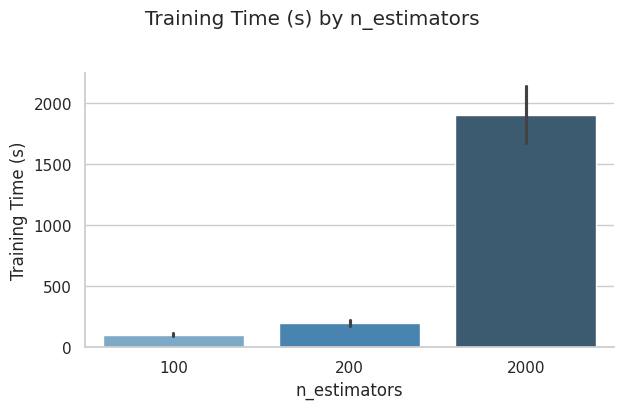

<ipython-input-19-29ba98f6d6d8>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


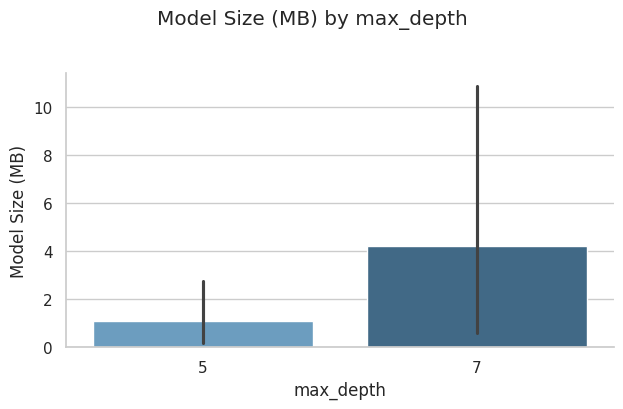

In [20]:
plot_metric_warp(df_results, metric="train_time", y_label="Training Time (s)")
plot_metric_warp(df_results, metric="model_size_mb", y_label="Model Size (MB)", x="max_depth")


# 🔮 WarpGBM Validation & Prediction Profiling

This notebook runs **inference + prediction time profiling** for all trained WarpGBM models using saved artifacts from the training benchmark.

---

## 🎯 Objective:
For each model:
- Load from `.pth`
- Predict on validation set
- Profile prediction time
- Save `.parquet` with:
  - `prediction`

---

## 📦 Inputs:
- `benchmark_log.csv` (from training notebook)

## 📂 Outputs:
- `*.parquet` files for each model
- Updated `benchmark_log_with_preds.csv` with:
  - `predict_time`
  - `pred_path`

---

⚠️ This notebook focuses **only on inference + saving predictions**.  
Validation metrics (e.g., CORR20v2, FNCv3) are computed in the next notebook.


In [21]:
napi.download_dataset(f"{DATA_VERSION}/validation.parquet")

v5.0/validation.parquet: 3.37GB [04:21, 12.9MB/s]                            


'v5.0/validation.parquet'

In [6]:
COLUMNS = ["era"] + feature_set + targets
df_val = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=COLUMNS
)

In [7]:
X_val = df_val[feature_set].values.astype(np.int8)


In [8]:
import torch
import time
import pandas as pd
from pathlib import Path

def run_prediction_and_save(row, X_val, output_dir):

    model_path = Path(row["model_path"])
    model_id = row["model_id"]

    assert row["model_type"] == "WarpGBM", f"Only WarpGBM supported for now, got: {row['model_type']}"
    pred_path = output_dir / f"{model_id}_preds.parquet"

    model = WarpGBM(row['num_bins'],
                    row['max_depth'],
                    row['learning_rate'],
                    row['n_estimators'])
    model.load_model(model_path)

    # Predict + profile
    start_pred = time.time()
    preds = model.predict(X_val, chunk_size=1000_000)
    df_val['prediction'] = preds
    df_val[['prediction']].rank(pct=True).to_parquet(pred_path)
    pred_time = time.time() - start_pred

    # Update row with new info
    row["predict_time"] = round(pred_time, 3)
    row["pred_path"] = str(pred_path)

    return row


In [9]:
from tqdm import tqdm
import pandas as pd
from pathlib import Path

# Paths
LOG_PATH = Path("/content/benchmark_outputs/20250410_1727/benchmark_log.csv")  # update timestamp
OUTPUT_DIR = LOG_PATH.parent

# Load log
df_log = pd.read_csv(LOG_PATH)
updated_rows = []

# Prediction runner
for i, row in tqdm(df_log.iterrows(), total=len(df_log), desc="🔮 Running Inference"):
    try:
        torch.cuda.empty_cache()
        gc.collect()
        updated = run_prediction_and_save(
            row=row,
            X_val=X_val,
            output_dir=OUTPUT_DIR
        )
        torch.cuda.empty_cache()
        gc.collect()
        updated_rows.append(updated)
    except Exception as e:
        print(f"⚠️ Error on {row['model_id']}: {e}")
        row["predict_time"] = None
        row["pred_path"] = None
        updated_rows.append(row)

# Save updated log
df_updated = pd.DataFrame(updated_rows)
out_path = OUTPUT_DIR / "benchmark_log_with_preds.csv"
df_updated.to_csv(out_path, index=False)
print(f"✅ Updated log saved to: {out_path}")


🔮 Running Inference: 100%|██████████| 6/6 [04:38<00:00, 46.46s/it]

✅ Updated log saved to: /content/benchmark_outputs/20250410_1727/benchmark_log_with_preds.csv


In [10]:
!zip -r /content/gridsearch_warpgbm_validation.zip /content/benchmark_outputs/20250410_1727


  adding: content/benchmark_outputs/20250410_1727/ (stored 0%)
  adding: content/benchmark_outputs/20250410_1727/benchmark_log_with_preds.csv (deflated 76%)
  adding: content/benchmark_outputs/20250410_1727/grid_005_WarpGBM_WarpGBM.pth (deflated 63%)
  adding: content/benchmark_outputs/20250410_1727/grid_002_WarpGBM_preds.parquet (deflated 17%)
  adding: content/benchmark_outputs/20250410_1727/benchmark_log.csv (deflated 70%)
  adding: content/benchmark_outputs/20250410_1727/grid_003_WarpGBM_preds.parquet (deflated 17%)
  adding: content/benchmark_outputs/20250410_1727/grid_001_WarpGBM_preds.parquet (deflated 17%)
  adding: content/benchmark_outputs/20250410_1727/grid_000_WarpGBM_WarpGBM.pth (deflated 70%)
  adding: content/benchmark_outputs/20250410_1727/grid_003_WarpGBM_WarpGBM.pth (deflated 65%)
  adding: content/benchmark_outputs/20250410_1727/grid_002_WarpGBM_WarpGBM.pth (deflated 63%)
  adding: content/benchmark_outputs/20250410_1727/grid_005_WarpGBM_preds.parquet (deflated 17%)
